In [1]:
# import all stuff we will need
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as st

from numpy.random import randn
from gbm_d import gbm_d

# 2.1 Discrete time model: the binomial tree

In a binomial tree with $m$ periods the are $m+1$ possible stock prices at maturity $T$

\begin{equation*}
s_{i,m}=s_{0,0}u^{i}d^{m-i},\quad i=0,\ldots,m
\end{equation*}

In each period, the stock price either increases by the factor $u=1+\sigma\sqrt{T/m}$ with probability $p$ or decreases by the factor $d=1-\sigma\sqrt{T/m}$ with probability $q=1-p$. Thus, the probability that the stock price $S_m$ attains the value $s_{i,m}$ is

\begin{equation*}
\mathbb{P}[S_m=s_{i,m}]=\binom{m}{i}p^{i}q^{m-i},\quad i=0,\ldots,m\;.
\end{equation*}

We are interested in the limit of $S_m$ as $m\rightarrow \infty$. As it becomes clear in the script, the random variable $S_m$ tends (in distribution) to the continuous random variable $S_T$, which is lognormal. This is cleary visible in the next plot: the cdf of $S_m$ converges (pointwise) to the cdf of $S_T$. Note carefully that the probability mass function of $S_m$ does not converge to the probability density function of $S_T$...

In [12]:
s0 = 10; sigma = 0.3; p = 0.5; # parameters of the stock

T = 0.5; m = 20**2;  dt = T/m; # parameters of the binomial tree 
u = 1+sigma*np.sqrt(dt); d = 1-sigma*np.sqrt(dt);

# the stock prices at maturity and the corresponding probabilities
sm = s0*u**np.arange(0,m+1,1)*d**(m-np.arange(0,m+1,1))
pm = st.binom.pmf(np.arange(0,m+1,1),m,p)

# generate randomly 'n_sims' stock prices at maturity, i.e., we draw from a binomial distribution 
n_sims = 2*10**5;
up_or_down = np.random.binomial(m,p,(n_sims,1))
sj_final = s0*u**up_or_down*d**(m-up_or_down)

# fit the lognormal distribution to the above data: 
# this shows that the stock prices at maturity should be lognormal (as m tends to infinity) 
args = st.lognorm.fit(sj_final,floc=0)

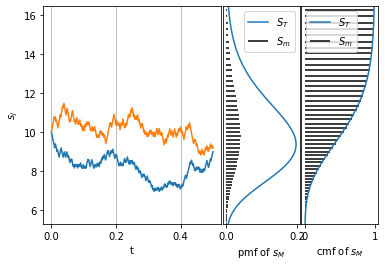

In [13]:
# graphical output
t = np.arange(0,T+dt,dt)
fig = plt.figure(1)
gridspec.GridSpec(1,30)
ax1 = plt.subplot2grid((1,30), (0,0), colspan=16, rowspan=1)

N = 2; # number of paths

# generate N paths and plot them
# create randomly N sequences (of length m) of zeros and ones
# 0 is interpreted as a down-movement, 1 as an up-movement
up_or_down = np.random.binomial(1,p,(m,N)) 
sj = np.zeros((m+1,N)); sj[0,:] = s0*np.ones((1,N))
for j in range(0,m):
    sj[j+1] = sj[j]*(u*(up_or_down[j]>0)+d*(up_or_down[j]<1))

ax1.plot(t,sj); ax1.xaxis.grid()

mean = np.sum(pm*sm); std = np.sqrt(np.sum(pm*sm**2)-mean**2)
ymin = mean-2.2*std; ymax = mean+3*std;
ax1.set_ylim([ymin,ymax]); plt.xlabel('t'); plt.ylabel('$s_j$');
 
# plot the pmf and pdf of Sm and ST, respectivly
ax2 = plt.subplot2grid((1,30), (0,16),colspan=7, rowspan=1)
ax2.hlines(sm,0,pm);
ax2.plot(st.lognorm.pdf(sm,*args),sm)
ax2.legend(('$S_T$','$S_m$'))
ax2.set_ylim([ymin,ymax])
ax2.axes.get_yaxis().set_visible(False)
plt.xlabel('pmf of $s_M$');

# plot the cdf's of both distributions
ax3 = plt.subplot2grid((1,30), (0,23),colspan=7, rowspan=1)
ax3.hlines(sm,0,np.cumsum(pm));
ax3.plot(st.lognorm.cdf(sm,*args),sm)
ax3.legend(('$S_T$','$S_m$'))
ax3.set_ylim([ymin,ymax])
ax3.axes.get_yaxis().set_visible(False)
plt.xlabel('cmf of $s_M$');

In [ ]:
# 2.2 Continuous time model: the geometric Brownian motion

As we have seen above, the binomial tree model 

\begin{equation*}
s_{i,m}=s_{0,0}u^{i}d^{m-i},\quad i=0,\ldots,m
\end{equation*}

leads - by taking the limit $m\rightarrow \infty$ (a tree with infinitely many steps) - to the geometric Brownian motion

\begin{equation*}
S_t = se^{(\mu-\frac{1}{2}\sigma^2)t+\sigma W_t}\;,
\end{equation*}

where $W_t$ is a stochastic process called <span style="color:red">Brownian motion</span>. It is defined as follows

### Definition 2.1

i) $W_0=0$.

ii) $W_t$ has independent and normally distributed increments, i.e., for any 

\begin{equation*}
0=t_0<t_1<t_2<\ldots<t_{n-1}<t_n\;,
\end{equation*}

and any $n\in\mathbb{N}^\times$ the $n$ random variables (the increments)

\begin{equation*}
X_1:=W_{t_1}-W_{t_0},\;\; X_2:=W_{t_2}-W_{t_1},\;\;\ldots,\;\; X_n:=W_{t_n}-W_{t_{n-1}}
\end{equation*}

are independent and there holds

\begin{equation*}
X_j\sim\mathcal{N}(0,t_j-t_{j-1})\;.
\end{equation*}

iii) $W_t$ is continuous in $t$.


The log-return

\begin{equation*}
R^c_{t_{k-1},t_k}:=\ln\frac{S_{t_k}}{S_{t_{k-1}}}
\end{equation*}

of the stock over the time period $[t_{k-1},t_k]$ with length $\Delta t= t_{k}-t_{k-1}$ in this model is

\begin{eqnarray*}
R^c_{t_{k-1},t_k} & = & \ln\frac{S_{t_k}}{S_{t_{k-1}}} \\
&=& \ln\frac{se^{(\mu-\frac{\sigma^2}{2})t_k+\sigma W_{t_k}}}{se^{(\mu-\frac{\sigma^2}{2})t_{k-1}+\sigma W_{t_{k-1}}}}\\
& = & \ln e^{(\mu-\frac{\sigma^2}{2})(t_k-t_{k-1})+\sigma (W_{t_k}-W_{t_{k-1}})}\\
& = & \Big(\mu-\frac{\sigma^2}{2}\Big)\Delta t+\sigma X_k\;.
\end{eqnarray*}

Hence, the log-return is normally distributed, with mean $(\mu-\sigma^2/2)\Delta t$ and standard deviation $\sigma\sqrt{\Delta t}$. This is in principle the whole story of the Black-Scholes-Merton theory: <span style="color:red">the log-return of the underlying is normal</span>.

# 2.3 Generating paths of a geometric Brownian motion

To simulate a path $(t_j,s_{t_j})$ with $t_j=j\Delta t$, $j=1,2,\ldots,n$ of a geometric Brownian motion

\begin{equation*}
S_t = s_0e^{(\mu-\frac{1}{2}\sigma^2)t+\sigma W_t}\;,
\end{equation*}

we have to draw $n$ realisations $z_\ell$ of the standard normal distribution, then to build the sum

\begin{equation*}
w_{t_j}=\sqrt{\Delta t}\sum_{\ell=1}^jz_\ell
\end{equation*}

and to evaluate 

\begin{equation*}
s_{t_j}=s_0e^{(\mu-\frac{1}{2}\sigma^2)t_j+\sigma \sqrt{\Delta t}\sum_{\ell=1}^jz_\ell}\;.
\end{equation*}

Details can be found in the script. Below you'll find a Python code which does the job. Note that it generates not just one path, but $N$ paths.

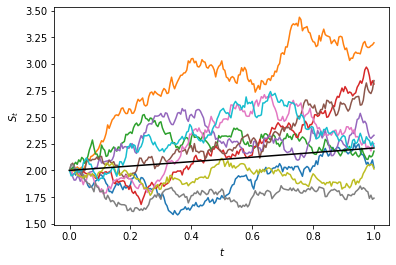

In [5]:
n = 200; N = 10; # n number of time points, N number of paths
s0 = 2; sigma = 0.2; mu = 0.1; T = 1; # parameters of geometric Brownian motion

dt = T/n; tj = np.arange(dt,T+dt,dt); 
tj = np.reshape(np.asarray(tj),[n,1]); t = np.vstack((0.0,tj))    

Z = randn(N,n); X = np.cumsum(Z,axis=1)

s = s0*np.exp((mu-0.5*sigma**2)*tj+sigma*np.sqrt(dt)*X.T) # the stock prices at tj
s0 = np.repeat(s0,N); s = np.vstack((np.asarray(s0),s)) # the stock prices at tj, including s0

plt.plot(t,s); # plot all the paths
plt.plot(t,s0[0]*np.exp(mu*t),'k-'); # plot the expectation of St
plt.xlabel('$t$'); plt.ylabel('$S_t$');

# 2.4 Multivariate geometric Brownian motion

An "obvious way" to generalise the geometric Browian motion to multiple underlyings is to consider the $d$ stochastic differential equations

\begin{equation*}
{\rm d}S^i_t=\mu_iS^i_t{\rm d}t+\sigma_iS^i_t{\rm d}\widehat{W}^i_t,\quad S_0^i=s_i>0
\end{equation*}

with solution 

\begin{equation*}
S^i_t=s_ie^{(\mu_i-\frac{1}{2}\sigma_i^2)t+\sigma_i\widehat{W}^i_t}\;.
\end{equation*}

The Brownian motions $\widehat{W}^i_t$ are not independent but have the covariance/correlation matrix $\boldsymbol{\rho}=(\rho_{ij})$; details are given in the script.

The function <span style="color:orange">gbm_d.py</span> generates one path of $\textbf{S}_t:=(S_t^1,S_t^2,\ldots,S_t^d)$ for time points $t\in\{t_1,t_2,\ldots,t_n\}$. The function is described in the technical note in section 2.8 below. 

# 2.8 Technical note. Simulation a $d$-dimensional geometric Brownian motion

The function <span style="color:orange">gbm_d(s0,mu,Sigma,Tau,T,dt)</span> gives one path of a $d$-dimensional geometric Brownian motion, i.e.,

\begin{equation*}
S^i_t=s_ie^{(\mu_i-\frac{1}{2}\sigma_i^2)t+\sigma_i\widehat{W}^i_t}
\end{equation*}

at time points defined in $\mathcal{T} =\{t_1,\ldots,t_n\}$. If $\mathcal{T}$ is empty then $t_j = j\textrm{d}t$, $j=1,\ldots,\frac{T}{\textrm{d}t}$. 

For the construction of the correlated Brownian motions $\widehat{W}^i_t$, $i=1,\ldots,d$ see the script.

In [6]:
# %load gbm_d.py
import numpy as np
from numpy.random import randn

def gbm_d(s0,mu,Sigma,Tau,T,dt):
    '''S,t = gbm_d(s0,mu,Sigma,Tau,T,dt) simulates one path of a d-dimensional 
       geometric Brownian motion 
       
       S = [S_0,S_t1,S_t2,...,S_T]
       
       at the time points specified in the list Tau = [t1,t2,...,T]. Each S_tj
       is a (row) array of length d (the GBM evaluated at tj).
       If Tau = [] is empty, the time points are evenly spaced, tj = j*dt, 
       with time step dt.
       
       s0 is a list of length d containing the initital values, mu is list of
       length d containing the drifts Sigma is the d-times-d covariance matrix.
       
       Example:
       s0 = [234,67]; mu = [0.037,0.027]
       Sigma = np.array([[0.18**2,0.18*0.15*0.68],[0.18*0.15*0.68,0.15**2]])
       S,t = gbm_d(s0,mu,Sigma,Tau,T,dt)
       plt.plot(S[:,0],S[:,1])
    '''
    
    if not Tau: # Tau is empty: we use evenly spaced time points in ]0,T]
        t = np.arange(dt,T+dt,dt);
    else: # Tau is not empty:
        t = Tau
    
    d = len(s0); n = len(t) # the dimensions
    
    # convert to arrays 
    s0 = np.reshape(np.asarray(s0),[1,d]) 
    mu = np.reshape(np.asarray(mu),[1,d])
    t = np.reshape(np.asarray(t),[n,1])
    t0 = np.vstack((0.0,t))
     
    L = np.linalg.cholesky(Sigma) # the Cholesky decomposition
    Z = randn(d,n); 
    sqrtDT = np.repeat(np.sqrt(np.diff(t0.T)),d,axis=0)

    X = np.cumsum(sqrtDT*Z,axis=1)
    A = np.repeat((mu-0.5*np.diag(Sigma)),n,axis=0)
    T = np.repeat(t,d,axis=1); S0 = np.repeat(s0,n,axis=0)
    S = S0*np.exp(A*T+np.matmul(L,X).T); S = np.vstack((s0,S));
    
    return S,t0

Do an example for $d=2$. Let ${\bf S}_0=(S_0^1,S_0^2)=(234,67)$, $\boldsymbol{\mu}=(\mu_1,\mu_2)=(0.037,0.027)$ and

$$\boldsymbol{\Sigma}=\boldsymbol{\sigma}\boldsymbol{\rho}\boldsymbol{\sigma}:=
\begin{pmatrix}\sigma_1 &\\ & \sigma_2\end{pmatrix}\begin{pmatrix}1 & \rho\\ \rho & 1\end{pmatrix}\begin{pmatrix}\sigma_1 &\\ & \sigma_2\end{pmatrix}$$

with $\sigma_1=0.18$, $\sigma_{2}=0.15$ and $\rho=0.68$.

First, plot the map $t\mapsto (S_t^1,S_t^2)$ for $t=j\textrm{d}t$ with $\textrm{d}t=\frac{1}{4\cdot 252}$. Add starting and ending point $(S_0^1,S_0^2)$ and $(S_T^1,S_T^2)$, respectively.

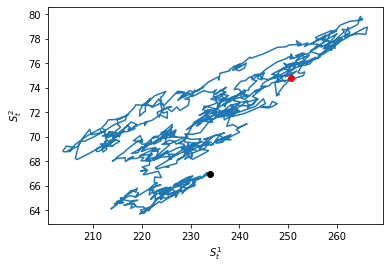

In [7]:
s0 = [234,67]; mu = [0.037,0.027]
sigma = np.diag([0.18,0.15]); rho = np.array([[1,0.68],[0,1]]); 
rho = rho+rho.T-np.eye(2); Sigma = sigma.dot(rho).dot(sigma)
S,t = gbm_d(s0,mu,Sigma,[],1,1/(4*252))
plt.plot(S[:,0],S[:,1]);
plt.plot(s0[0],s0[1],'ko'); plt.plot(S[-1,0],S[-1,1],'ro'); # starting and ending point
plt.xlabel('$S_t^1$'); plt.ylabel('$S_t^2$');

In [ ]:
Now, plot the graphs $t\mapsto S_t^i$.

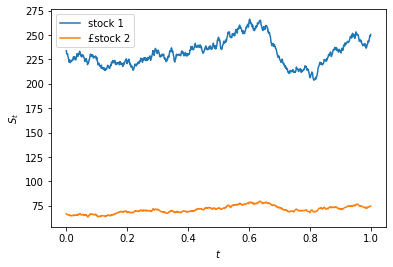

In [8]:
plt.plot(t,S); plt.xlabel('$t$'); plt.ylabel('$S_t$')
plt.legend(('stock 1','£stock 2'));

In [ ]:
To better compare the two stocks, we normalize them, i.e., we consider the graphs $t\mapsto\frac{S_t^i}{S_0^i}$.

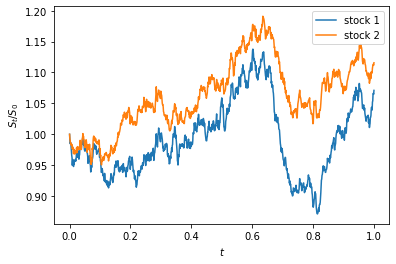

In [9]:
plt.plot(t,S/np.asarray(s0)); plt.xlabel('$t$'); plt.ylabel('$S_t/S_0$')
plt.legend(('stock 1','stock 2'));

Now do an example for $d=3$. Let ${\bf S}_0=(S_0^1,S_0^2,S_0^3)=(70,80,263)$, $\boldsymbol{\mu}=(\mu_1,\mu_2,\mu_3)=(0.03,0.05,0.02)$ and

$$\boldsymbol{\Sigma}=\boldsymbol{\sigma}\boldsymbol{\rho}\boldsymbol{\sigma}:=
\begin{pmatrix}\sigma_1 & &\\ & \sigma_2 & \\ & & \sigma_3\end{pmatrix}\begin{pmatrix}1 & \rho_{12}& \rho_{13}\\ \rho_{12} & 1 & \rho_{23} \\ \rho_{13}& \rho_{23} & 1\end{pmatrix}\begin{pmatrix}\sigma_1 & &\\ & \sigma_2 & \\ & & \sigma_3\end{pmatrix}$$

with $\sigma_1=0.1$, $\sigma_{2}=0.2$, $\sigma_3=0.4$ and $\rho_{12}=0.8$, $\rho_{13}=-0.5$, $\rho_{23}=-0.7$.

First, plot the map $t\mapsto (S_t^1,S_t^2,S_t^3)$ for $t=j\textrm{d}t$ with $\textrm{d}t=\frac{1}{4\cdot 252}$. Add starting and ending point $(S_0^1,S_0^2,S_0^3)$ and $(S_T^1,S_T^2,S_T^3)$, respectively.

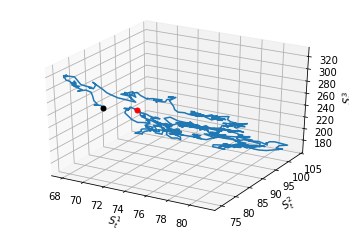

In [10]:
s0 = [70,80,263]; mu = [0.03,0.05,0.02];
sigma = np.diag([0.1,0.2,0.4]); 
rho = np.array([[1,0.8,-0.5],[0,1,-0.7],[0,0,1]]); 
rho = rho+rho.T-np.eye(3); Sigma = sigma.dot(rho).dot(sigma)
S,t = gbm_d(s0,mu,Sigma,[],1,1/(2*252))

ax = plt.axes(projection='3d')

ax.scatter3D(S[0,0],S[0,1],S[0,2],c='k',marker='.',s=100); # starting point is black
ax.scatter3D(S[-1,0],S[-1,1],S[-1,2],c='r',marker='.',s=100); # ending point is red
ax.plot3D(S[:,0],S[:,1],S[:,2]);
ax.set_xlabel('$S_t^1$'), ax.set_ylabel('$S_t^2$'), ax.set_zlabel('$S_t^3$');

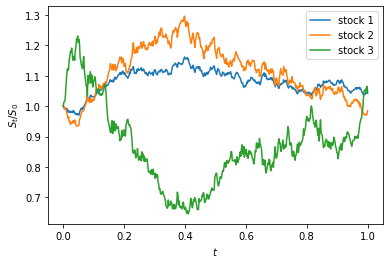

In [11]:
plt.plot(t,S/np.asarray(s0)); plt.xlabel('$t$'); plt.ylabel('$S_t/S_0$')
plt.legend(('stock 1','stock 2','stock 3'));